In [1]:
import pandas as pd
import glob
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)qtl', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))

                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value

            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [3]:
linear_df = harvest_mod_outputs('./gplinear', 'qhaplo_*qtl_*n_rep*_phenotype_correlations_untuned.csv')
neural_df = harvest_mod_outputs('./gpnet', 'qhaplo_*qtl_*n_rep*_phenotype_correlations_untuned.csv')


   trait_number  pearson_correlation  p_value  true_mean  pred_mean  true_std  \
0             1             0.998541      0.0  -0.005308   0.005000  0.999202   
1             2             0.896942      0.0  -0.002408  -0.016737  1.007783   
2             3             0.677698      0.0  -0.003273  -0.004532  0.998969   
3             4             0.550198      0.0   0.002280   0.017836  0.996942   
4             5             0.360087      0.0  -0.005150  -0.005316  1.000086   

   pred_std trait_architecture  qtl_param  n_param  rep  
0  0.769702                1-5       2002   100000    2  
1  0.530100                1-5       2002   100000    2  
2  0.357462                1-5       2002   100000    2  
3  0.282274                1-5       2002   100000    2  
4  0.189693                1-5       2002   100000    2  
   trait_number  pearson_correlation  true_mean  pred_mean  true_std  \
0             1             0.997797  -0.005308  -0.253626  0.999201   
1             2      

In [4]:
linear_df.rename(columns={'pearson_correlation':'pearson_correlation'}, inplace=True)
neural_df.rename(columns={'pearson_correlation':'pearson_correlation'}, inplace=True)


In [5]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'rep'])

    return common_params

In [6]:
common_params = get_parameter_combinations(linear_df, neural_df)


In [7]:
def generate_comparison_df(df1, df2, common_params):
    """
    Generates paired comparison dataframe from two input dataframes that contain prediciton results from different models

    Args: The two dataframes to compare, and common param combinations
    Returns: Single dataframe with paired up outputs
    """
    comparison_data = []

    for _, row in common_params.iterrows():
        qtl = row['qtl_param']
        n = row['n_param']
        trait = row['trait_number']
        rep = row['rep']

        linear_row = df1[(df1['qtl_param'] == qtl) &
                            (df1['n_param'] == n) &
                            (df1['trait_number'] == trait) &
                            (df1['rep'] == rep)]

        neural_row = df2[(df2['qtl_param'] == qtl) &
                            (df2['n_param'] == n) &
                            (df2['trait_number'] == trait)&
                            (df2['rep'] == rep)]

        if not linear_row.empty and not neural_row.empty:
            comparison_data.append({
                'qtl_param': qtl,
                'n_param': n,
                'trait_number': trait,
                'rep': rep,
                'linear_correlation': linear_row['pearson_correlation'].values[0],
                'neural_correlation': neural_row['pearson_correlation'].values[0],
                'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
            })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df


In [8]:
comparison_df = generate_comparison_df(linear_df, neural_df, common_params)


In [9]:
comparison_df

,qtl_param,n_param,trait_number,rep,linear_correlation,neural_correlation,difference
0,2002,100000,1,2,0.998541,0.997797,-0.000744
1,2002,100000,2,2,0.896942,0.886550,-0.011586
2,2002,100000,3,2,0.677698,0.657882,-0.029241
3,2002,100000,4,2,0.550198,0.517199,-0.059977
4,2002,100000,5,2,0.360087,0.334804,-0.070212
...,...,...,...,...,...,...,...
1295,1002,1000000,1,1,0.999400,0.999458,0.000058
1296,1002,1000000,2,1,0.909765,0.953043,0.047571
1297,1002,1000000,3,1,0.694123,0.887865,0.279117
1298,1002,1000000,4,1,0.582456,0.858307,0.473600


In [10]:
def plot_difference_scatter(comparison_df):
    """
    Creates a scatter plot with fitted splines showing the difference between neural and linear models,
    with QTL number on x-axis (log scaled) and difference on y-axis.
    Points and splines are colored by sample size.
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Get unique traits and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_traits, figsize=(5*num_traits, 6), sharey=True)

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Create a colormap for sample sizes
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(unique_n)))

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # For each sample size, plot points and fit a smoother curve
        for j, n in enumerate(unique_n):
            # Filter data for this sample size
            n_data = trait_data[trait_data['n_param'] == n]

            # Sort by QTL parameter for proper fitting
            n_data = n_data.sort_values('qtl_param')

            # Extract x and y data
            x_data = n_data['qtl_param'].values
            y_data = n_data['difference'].values

            # Plot the scatter points
            axes[i].scatter(x_data, y_data, color=colors[j], s=50, alpha=0.7)

            # Only proceed if we have enough data points
            if len(x_data) >= 4:
                # Use log of x for fitting to handle the log scale properly
                log_x = np.log10(x_data)

                # Fit a smoother spline with regularization
                # Adjust smoothing factor s to control how closely the curve follows points
                s = len(x_data) * 0.5  # Adjust this value as needed
                try:
                    spline = UnivariateSpline(log_x, y_data, s=s)

                    # Create smooth points for plotting
                    log_x_smooth = np.linspace(min(log_x), max(log_x), 100)
                    y_smooth = spline(log_x_smooth)

                    # Convert back to original scale for plotting
                    x_smooth = 10**log_x_smooth

                    # Plot the smoothed line
                    axes[i].plot(x_smooth, y_smooth, '-', color=colors[j],
                                linewidth=2, label=f'n = {n}' if i == 0 else "")
                except Exception:
                    # If spline fitting fails, use a simpler approach
                    # Just connect the points with straight lines
                    axes[i].plot(x_data, y_data, '-', color=colors[j], alpha=0.5,
                                linewidth=1.5, label=f'n = {n}' if i == 0 else "")

        # Set x-axis to log scale
        axes[i].set_xscale('log')

        # Add a horizontal line at y=0
        axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.7)

        # Set title and labels
        axes[i].set_title(f'Trait {trait}')
        axes[i].set_xlabel('QTL Number (log scale)')

        if i == 0:
            axes[i].set_ylabel('Difference (Neural - Linear)')

        # Set y-axis limits consistently
        y_max = abs(comparison_df['difference']).max() * 1.1  # Add 10% padding
        axes[i].set_ylim(-1, 3)

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.005),
              ncol=len(unique_n), title="Sample Size")

    plt.suptitle('Neural Network vs Linear Model Performance Difference by Trait', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout for suptitle and legend


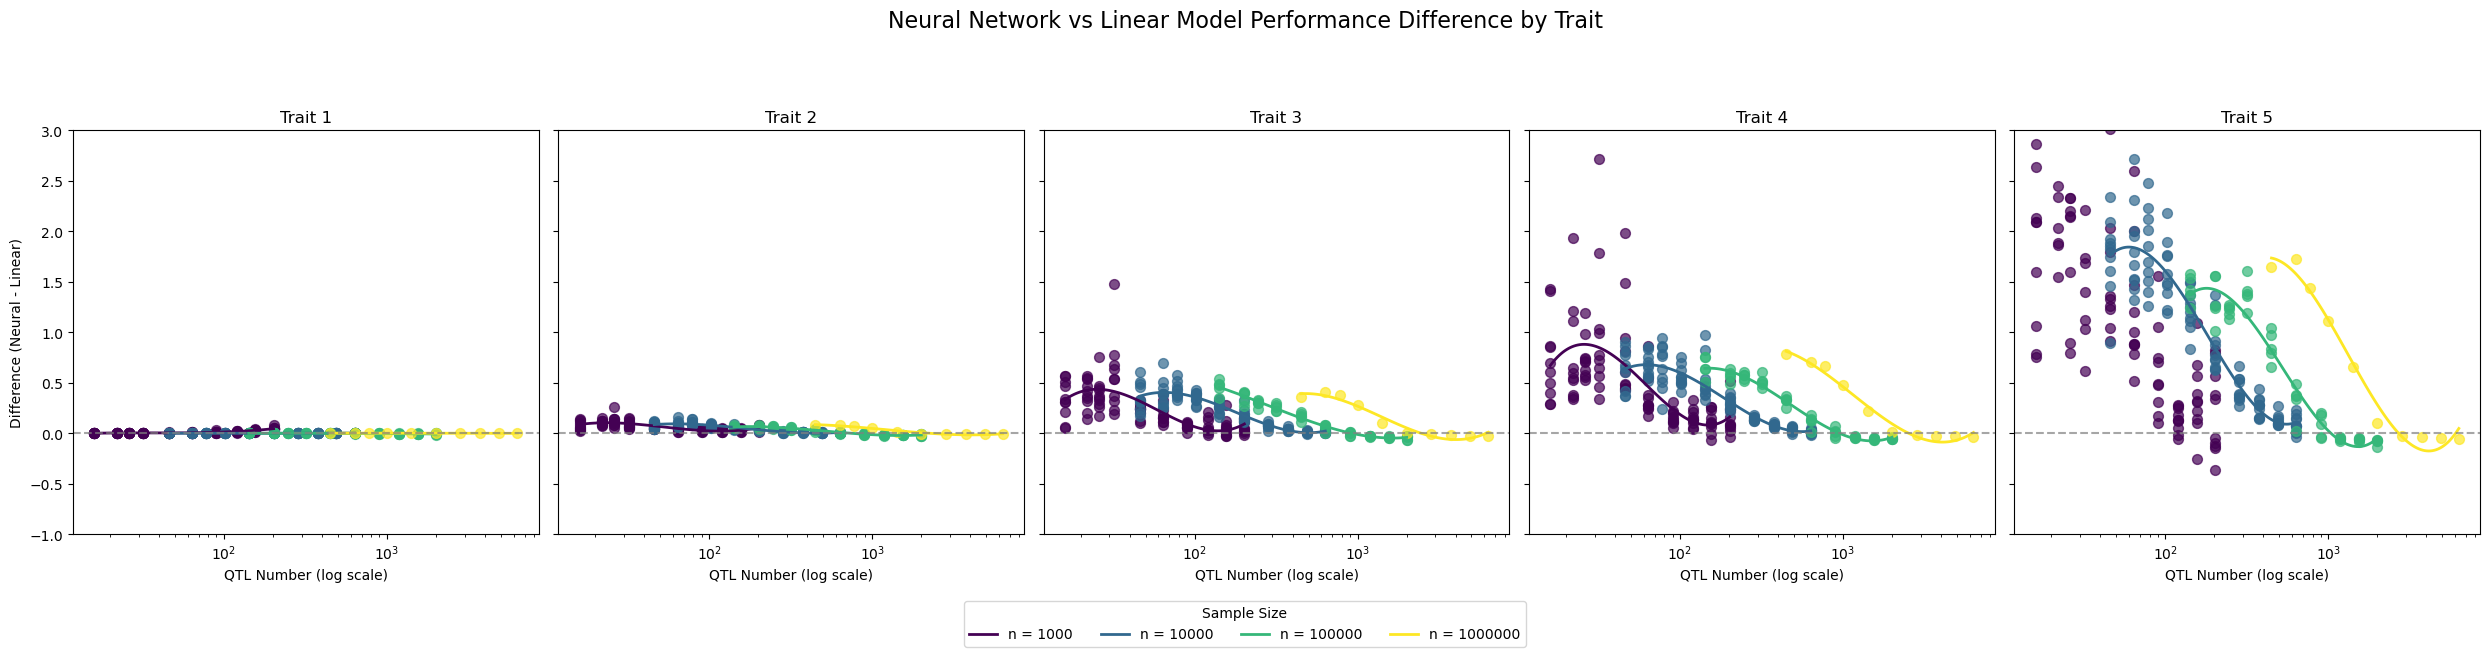

In [11]:
plot_difference_scatter(comparison_df)

In [12]:
def plot_correlation_scatter(comparison_df, correlation_type='neural_correlation'):
    """
    Creates a scatter plot with fitted splines showing the specified correlation type,
    with QTL number on x-axis (log scaled) and correlation on y-axis.
    Points and splines are colored by sample size.

    Parameters:
    -----------
    comparison_df : pandas DataFrame
        The data frame containing the correlation data
    correlation_type : str, optional
        The type of correlation to plot. Default is 'neural_correlation'
        Options: 'neural_correlation', 'linear_correlation', 'difference'
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Validate correlation type
    valid_types = ['neural_correlation', 'linear_correlation', 'difference']
    if correlation_type not in valid_types:
        raise ValueError(f"correlation_type must be one of {valid_types}")

    # Set the appropriate title and y-line based on correlation type
    if correlation_type == 'neural_correlation':
        plot_title = 'Neural Network Performance (r2) by Trait'
        y_line = 0.6  # Example threshold line
        y_label = 'Neural Network validation r2'
    elif correlation_type == 'linear_correlation':
        plot_title = 'Linear Model Performance (r2) by Trait'
        y_line = 0.6  # Example threshold line
        y_label = 'Linear Model validation r2'
    else:  # 'difference'
        plot_title = 'Neural Network vs Linear Model Performance Difference by Trait'
        y_line = 0  # Zero line for difference
        y_label = 'Difference (Neural - Linear)'

    # Get unique traits and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_traits, figsize=(5*num_traits, 6), sharey=True)

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Create a colormap for sample sizes
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(unique_n)))

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # For each sample size, plot points and fit a smoother curve
        for j, n in enumerate(unique_n):
            # Filter data for this sample size
            n_data = trait_data[trait_data['n_param'] == n]

            # Sort by QTL parameter for proper fitting
            n_data = n_data.sort_values('qtl_param')

            # Extract x and y data
            x_data = n_data['qtl_param'].values
            y_data = n_data[correlation_type].values

            # Plot the scatter points
            axes[i].scatter(x_data, y_data, color=colors[j], s=50, alpha=0.7)

            # Only proceed if we have enough data points
            if len(x_data) >= 4:
                # Use log of x for fitting to handle the log scale properly
                log_x = np.log10(x_data)

                # Fit a smoother spline with regularization
                # Adjust smoothing factor s to control how closely the curve follows points
                s = len(x_data) * 0.1  # Adjust this value as needed
                try:
                    spline = UnivariateSpline(log_x, y_data, s=s)

                    # Create smooth points for plotting
                    log_x_smooth = np.linspace(min(log_x), max(log_x), 100)
                    y_smooth = spline(log_x_smooth)

                    # Convert back to original scale for plotting
                    x_smooth = 10**log_x_smooth

                    # Plot the smoothed line
                    axes[i].plot(x_smooth, y_smooth, '-', color=colors[j],
                                linewidth=2, label=f'n = {n}' if i == 0 else "")
                except Exception:
                    # If spline fitting fails, use a simpler approach
                    # Just connect the points with straight lines
                    axes[i].plot(x_data, y_data, '-', color=colors[j], alpha=0.5,
                                linewidth=1.5, label=f'n = {n}' if i == 0 else "")

        # Set x-axis to log scale
        axes[i].set_xscale('log')

        # Add a reference line
        axes[i].axhline(y=y_line, color='gray', linestyle='--', alpha=0.7)

        # Set title and labels
        axes[i].set_title(f'Trait {trait}')
        axes[i].set_xlabel('QTL Number (log scale)')

        if i == 0:
            axes[i].set_ylabel(y_label)

        # Set y-axis limits based on correlation type
        if correlation_type == 'difference':
            y_max = abs(comparison_df[correlation_type]).max() * 1.1
            axes[i].set_ylim(-y_max, y_max)
        else:
            axes[i].set_ylim(0, 1.1)

    # Add legend with better positioning to avoid overlap
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),
              ncol=min(len(unique_n), 4), title="Sample Size")

    plt.suptitle(plot_title, fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])  # Adjusted to leave room for legend at bottom


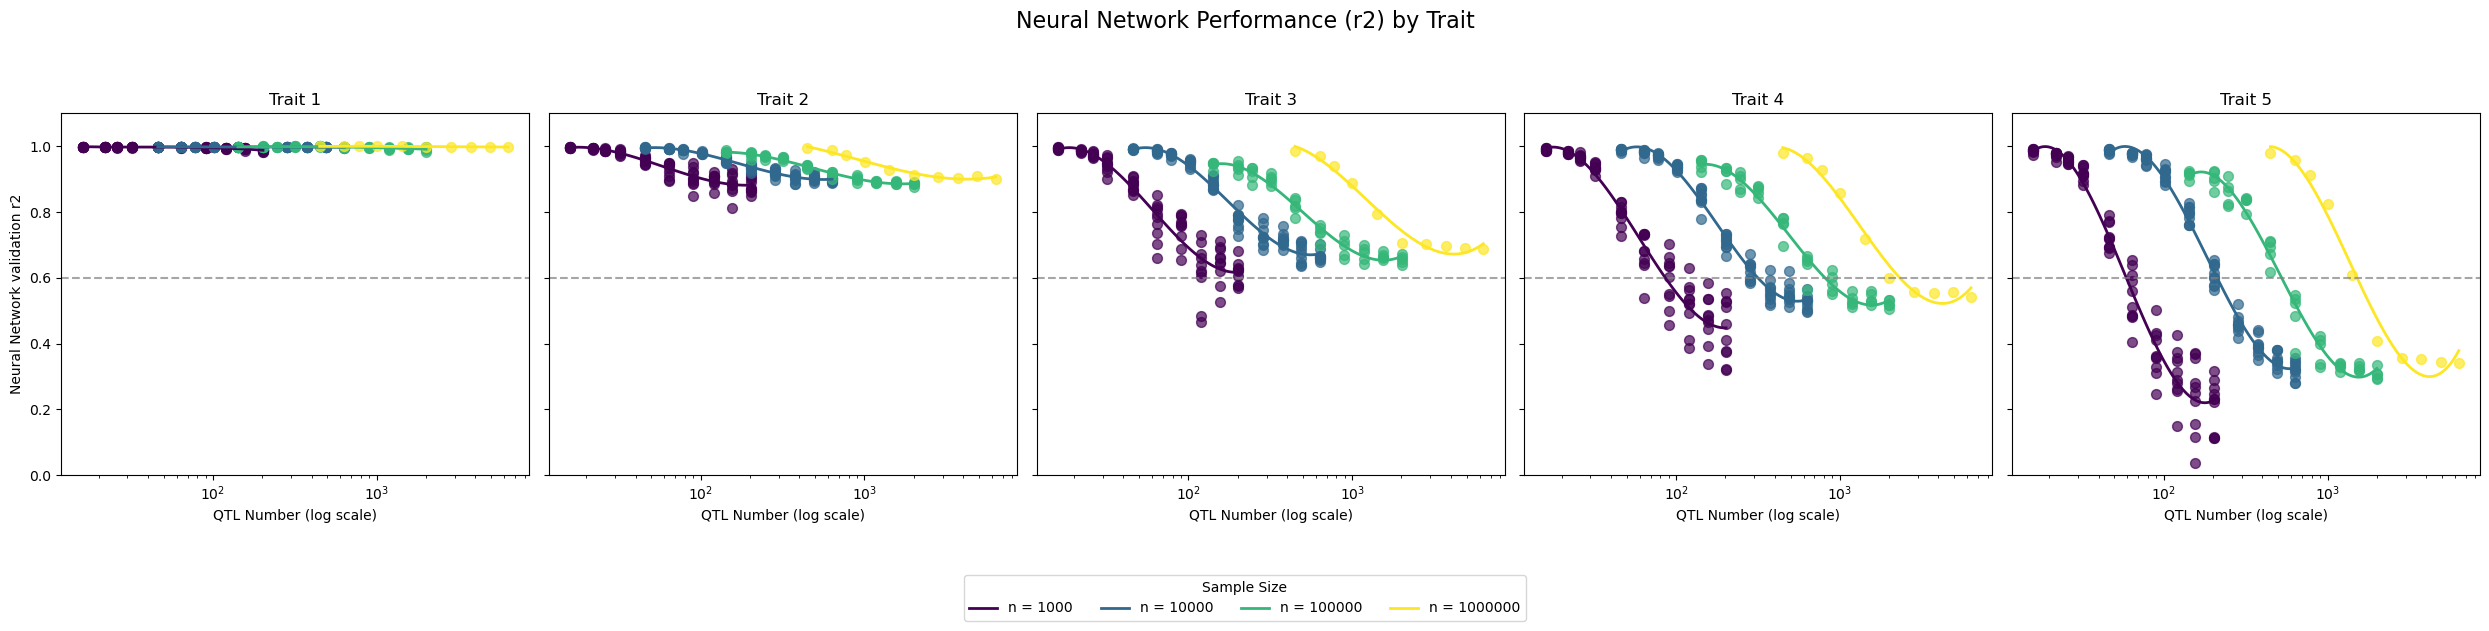

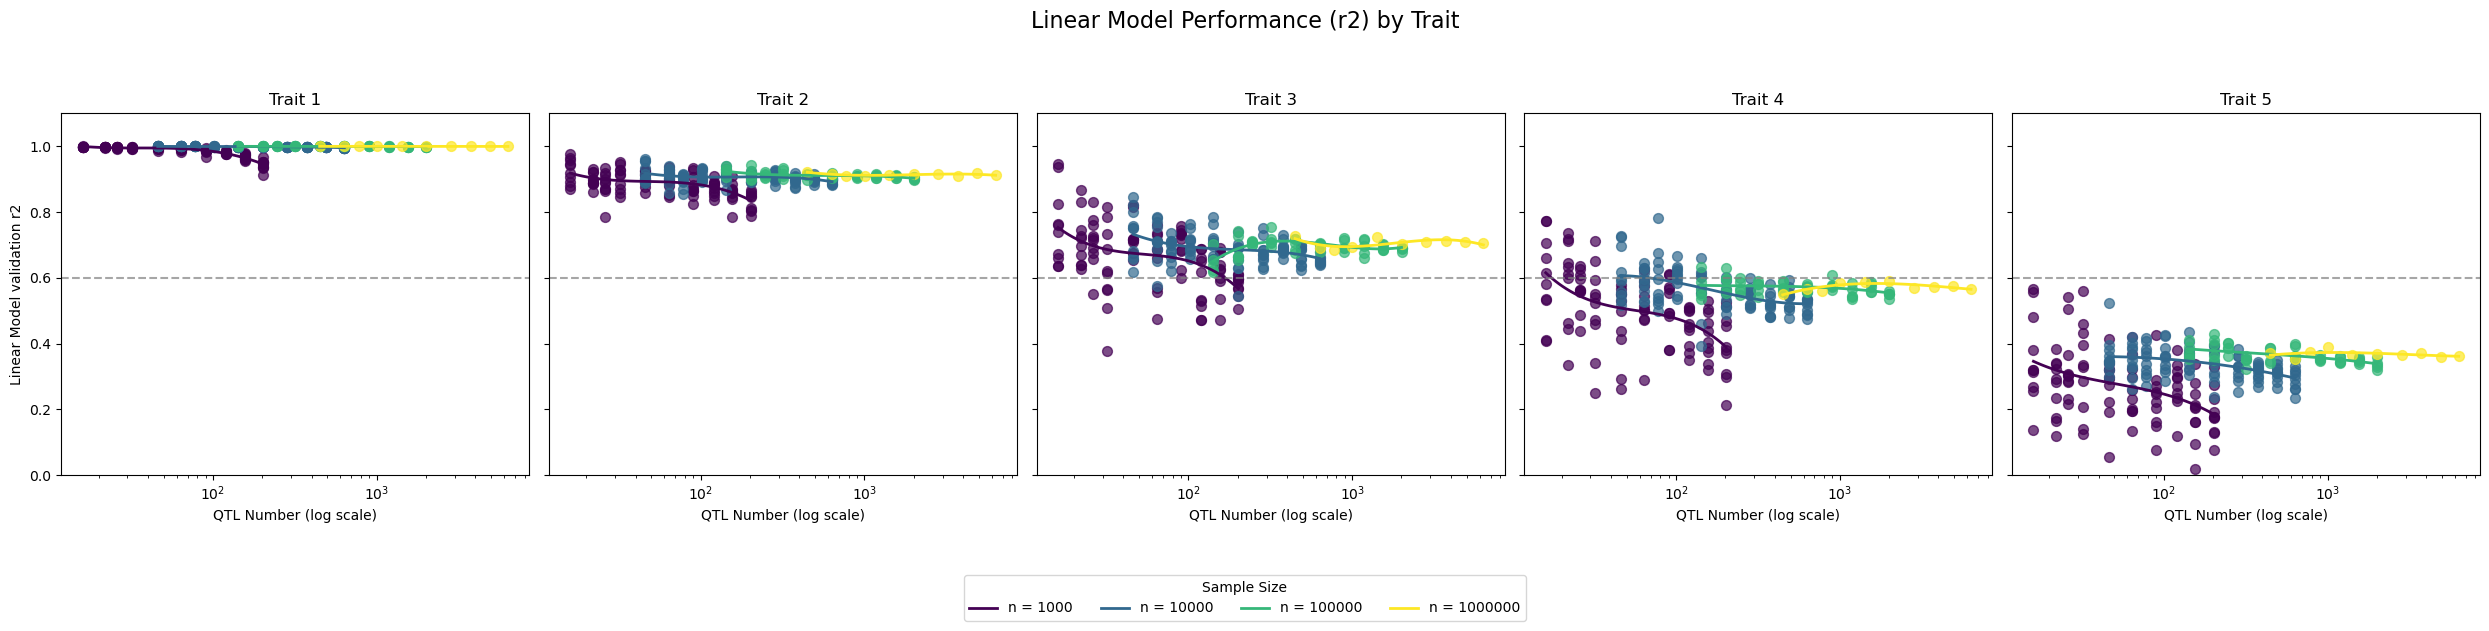

In [13]:
plot_correlation_scatter(comparison_df)
plot_correlation_scatter(comparison_df, correlation_type='linear_correlation')


   qtl_param  n_param  trait_number  rep  linear_correlation  \
0       2002   100000             1    2            0.998541   
1       2002   100000             2    2            0.896942   
2       2002   100000             3    2            0.677698   
3       2002   100000             4    2            0.550198   
4       2002   100000             5    2            0.360087   

   neural_correlation  difference  scaled_qtl_n      log_N  
0            0.997797   -0.000744      20.03001  11.512925  
1            0.886550   -0.011586      20.03001  11.512925  
2            0.657882   -0.029241      20.03001  11.512925  
3            0.517199   -0.059977      20.03001  11.512925  
4            0.334804   -0.070212      20.03001  11.512925  


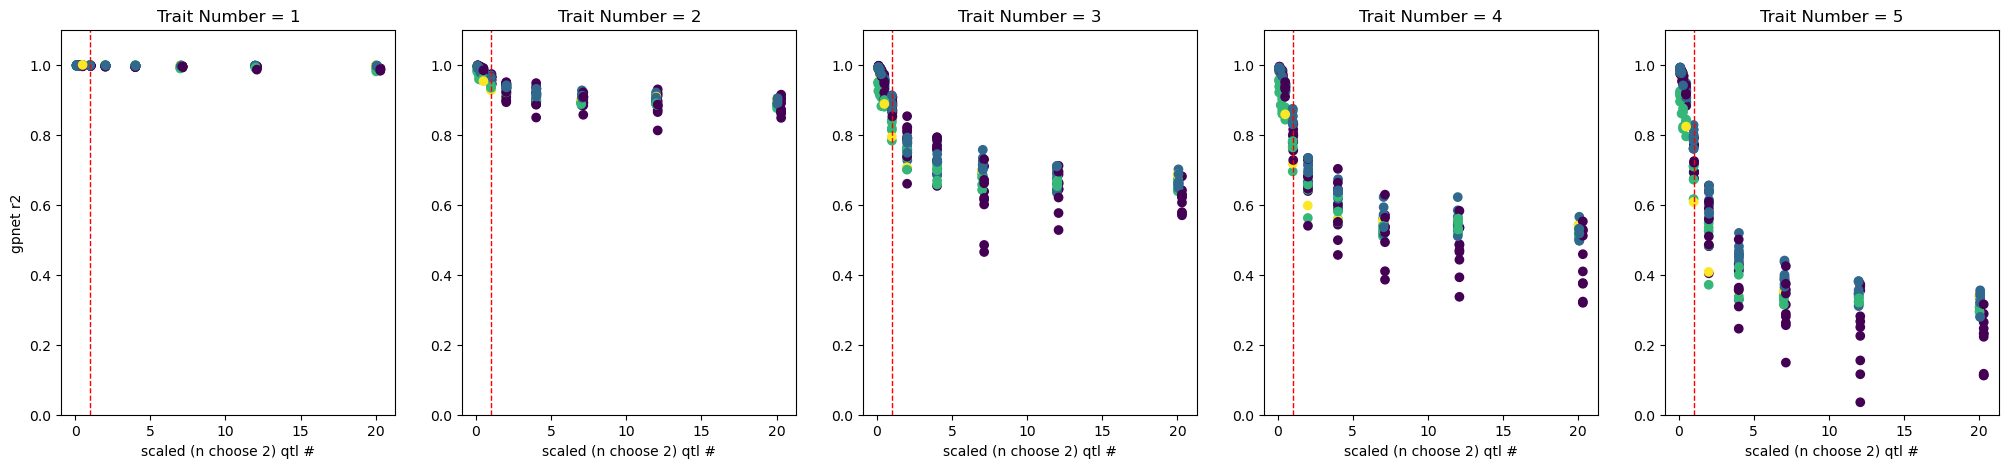

In [14]:

from matplotlib import gridspec
from scipy.special import comb

combination_values = []
for value in comparison_df['qtl_param']:
    combination_values.append(comb(value, 2))

comparison_df['scaled_qtl_n'] = combination_values/comparison_df['n_param']
#comparison_df['scaled_qtl_n'] = (comparison_df['qtl_param']^2)/comparison_df['n_param']

comparison_df['log_N'] = np.log(comparison_df['n_param'])

print(comparison_df.head())

# Get unique trait numbers
unique_traits = sorted(comparison_df['trait_number'].unique())
num_traits = len(unique_traits)

# Create figure with subplots
fig = plt.figure(figsize=(5*num_traits, 5))
gs = gridspec.GridSpec(1, num_traits)

# Create a subplot for each trait_number
for i, trait_num in enumerate(unique_traits):
    ax = plt.subplot(gs[i])

    # Filter data for current trait number
    trait_data = comparison_df[comparison_df['trait_number']==trait_num]

    # Create scatter plot with same parameters as your original
    scatter = ax.scatter(trait_data['scaled_qtl_n'], trait_data['neural_correlation'],
                         c=trait_data['log_N'], cmap='viridis')

    # Set consistent y-limits
    ax.set_ylim(0, 1.1)
    ax.grid(False)

    # Add vertical line at x=1
    ax.axvline(x=1, color='r', linestyle='--', linewidth=1)

    # Set labels
    ax.set_xlabel('scaled (n choose 2) qtl #')
    if i == 0:
        ax.set_ylabel('gpnet r2')

    # Add title for each subplot
    ax.set_title(f'Trait Number = {trait_num}')


Text(0, 0.5, 'gpnet r2')

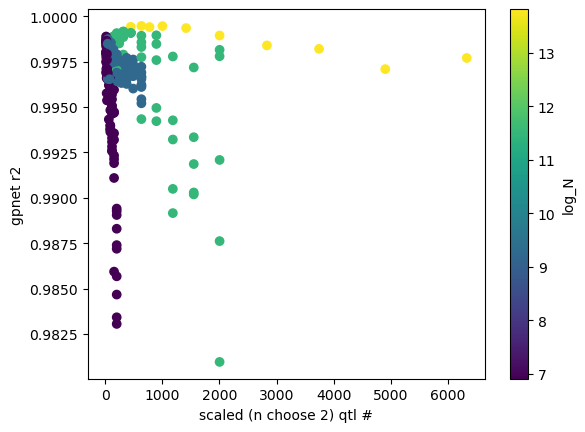

In [15]:
trait1 = comparison_df[comparison_df['trait_number']==1]
plt.scatter(trait1['qtl_param'], trait1['neural_correlation'], c=trait1['log_N'], cmap='viridis')
plt.colorbar( label='log_N')
plt.grid(False)
plt.xlabel('scaled (n choose 2) qtl #')
plt.ylabel('gpnet r2')